In this tutorial, we will introduce how to implement a Principal Component Analysis Autoencoder (PCAAE).

First of all, we import libraries

In [124]:
%%capture
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import os
import warnings
warnings.filterwarnings('ignore')

from skimage.draw import ellipse
from skimage.io import imsave
from skimage.filters import gaussian
from skimage import img_as_uint

import torchvision
import torch
from torch import nn

from torch import optim
import itertools

Get some parametres

In [125]:
np.random.seed(0) 
image_size = 64
num_image = 256*50
max_gray = 255.

save_training_image = False
path_data = 'dataset'

batchsize = 512
gpu = True
is_training = True
folder4weights = 'weights'
train_latent = 3
lambdacov = 1
lambdarec = 1
num_epoch = 80
lr = 0.001

if gpu:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

We will create a dataset of grayscale ellipse images

In [126]:
def generating_data(num_image,image_size=64,max_gray=255,save_training_image=False,path_data='.'):
    # Random set of radius and rotation coefficients
    set_radius_x = np.random.randint(image_size/8, image_size/2, size=num_image)
    set_radius_y = np.random.randint(image_size/8, image_size/2, size=num_image)
    set_rotation = np.random.randint(0, 90, size=num_image)
    
    if save_training_image:
        if not os.path.exists(path_data):
            os.makedirs(path_data)

    list_image = []    

    for n_image in range(num_image):
        img = np.zeros((image_size, image_size), dtype=np.uint8)
        radius_x = set_radius_x[n_image]
        radius_y = set_radius_y[n_image]
        rotation = set_rotation[n_image]

        rr, cc = ellipse(image_size/2, image_size/2, radius_x, radius_y, rotation=np.deg2rad(rotation))
        img[rr, cc] = max_gray
        img = gaussian(img, preserve_range=True)

        if save_training_image:
            imsave(path_data+'/ellipse_'+str(n_image)+'.png', img_as_uint(img))

        list_image.append(np.expand_dims(np.expand_dims(img,0),0))

    list_image = np.concatenate(list_image,0)
    return list_image
                    
train_images =  generating_data(num_image,image_size=image_size,max_gray=max_gray,save_training_image=False,path_data=path_data)

Verify our dataset

In [127]:
print(train_images.shape)
print(np.min(train_images),np.max(train_images))

(12800, 1, 64, 64)
0.0 255.0


Our dataset into GPU

In [128]:
train_dataset = torch.stack([torch.Tensor(i) for i in train_images])/ max_gray
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batchsize,
    num_workers=8,
    shuffle=True)

Create the networks: encoder and decoder

In [129]:
class Encoder(nn.Module):
    def __init__(self, code_size=1, kernel_size = 3, n_chan = 1):
        super(Encoder, self).__init__()        
        self.latent_dim = code_size
        
        # Convolutional layers
        cnn_kwargs = dict(stride=2, padding=1)
        self.conv1 = nn.Conv2d(n_chan, int(code_size*32), kernel_size, **cnn_kwargs)
        self.conv2 = nn.Conv2d(int(code_size*32), int(code_size*16), kernel_size, **cnn_kwargs)
        self.conv3 = nn.Conv2d(int(code_size*16), int(code_size*8), kernel_size, **cnn_kwargs)
        self.conv4 = nn.Conv2d(int(code_size*8), int(code_size*4), kernel_size, **cnn_kwargs)
        self.conv5 = nn.Conv2d(int(code_size*4), int(code_size*2), kernel_size, **cnn_kwargs)
        self.conv6 = nn.Conv2d(int(code_size*2), code_size, kernel_size, **cnn_kwargs)
        self.zero_mean = nn.BatchNorm1d(self.latent_dim, affine=False, eps=0)
        self.leaky = nn.LeakyReLU(0.2)
    def forward(self, x):
        batch_size = x.size(0)

        # Convolutional layers with ReLu activations
        x = self.leaky(self.conv1(x))
        x = self.leaky(self.conv2(x))
        x = self.leaky(self.conv3(x))
        x = self.leaky(self.conv4(x))
        x = self.leaky(self.conv5(x))
        x = self.conv6(x)
        z = x.view((batch_size, -1))
        z = self.zero_mean(z)
        return z  
    
class Decoder(nn.Module):
    def __init__(self, code_size=1, kernel_size = 3, n_chan = 1):
        super(Decoder, self).__init__()
        # Shape required to start transpose convs
        self.reshape = (code_size, 1, 1)
        
        # Convolutional layers
        cnn_kwargs = dict(stride=1, padding=1)
        self.convT6 = nn.Conv2d(code_size, int(code_size*2), kernel_size, **cnn_kwargs)
        self.convT5 = nn.Conv2d(int(code_size*2), int(code_size*4), kernel_size, **cnn_kwargs)
        self.convT4 = nn.Conv2d(int(code_size*4), int(code_size*8), kernel_size, **cnn_kwargs)
        self.convT3 = nn.Conv2d(int(code_size*8), int(code_size*16), kernel_size, **cnn_kwargs)
        self.convT2 = nn.Conv2d(int(code_size*16), int(code_size*32), kernel_size, **cnn_kwargs)
        self.convT1 = nn.Conv2d(int(code_size*32), n_chan, kernel_size, **cnn_kwargs)
        self.leaky = nn.LeakyReLU(0.2)
        self.upsample = nn.Upsample(scale_factor=2, mode='nearest')
        
    def forward(self, z):
        batch_size = z.size(0)
        x = z.view(batch_size, *self.reshape)
        
        # Convolutional layers with ReLu activations
        x = self.leaky(self.convT6(self.upsample(x)))
        x = self.leaky(self.convT5(self.upsample(x)))
        x = self.leaky(self.convT4(self.upsample(x)))
        x = self.leaky(self.convT3(self.upsample(x)))
        x = self.leaky(self.convT2(self.upsample(x)))
        # activation for final conv layer ?
        x = self.convT1(self.upsample(x))

        return x

Reconstruction loss

In [130]:
def reconstruction_loss(data, recon_data):
    return nn.MSELoss()(data,recon_data)

Train a vanilla autoencoder

In [131]:
def train_AE(E,D, optimizer, epoch,  train_loader, device):
    train_loss = 0      
    
    for batch_idx, (data) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        z = E(data)          
        recon_data = D(z)
        loss = reconstruction_loss(recon_data, data)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
            
    print('====> AE Epoch: {} Average loss: {:.8f}'.format(epoch, train_loss / len(train_loader.dataset)))

In [132]:
AE_E = Encoder(code_size=train_latent).to(device)
AE_D = Decoder(code_size=train_latent).to(device)
AE_optim = optim.Adam(itertools.chain(AE_E.parameters(),AE_D.parameters()), lr=lr, betas=(0.5, 0.999))

if is_training:
    print("Training AE for ellipses")
    weightname = folder4weights+'/AE_ellipses'
    for epoch in range(1, num_epoch + 1):
        train_AE(AE_E, AE_D, AE_optim, epoch, train_loader, device)
        torch.save( {'AE_E_state_dict': AE_E.state_dict(),
                     'AE_D_state_dict': AE_D.state_dict(),
                     'AE_optim_state_dict': AE_optim.state_dict(),}, 
                    weightname)  


Training AE for ellipses
====> AE Epoch: 1 Average loss: 0.00024138
====> AE Epoch: 2 Average loss: 0.00010069
====> AE Epoch: 3 Average loss: 0.00007647
====> AE Epoch: 4 Average loss: 0.00006866
====> AE Epoch: 5 Average loss: 0.00006542
====> AE Epoch: 6 Average loss: 0.00005782
====> AE Epoch: 7 Average loss: 0.00005962
====> AE Epoch: 8 Average loss: 0.00005394
====> AE Epoch: 9 Average loss: 0.00005058
====> AE Epoch: 10 Average loss: 0.00005404
====> AE Epoch: 11 Average loss: 0.00005401
====> AE Epoch: 12 Average loss: 0.00004229
====> AE Epoch: 13 Average loss: 0.00004317
====> AE Epoch: 14 Average loss: 0.00004524
====> AE Epoch: 15 Average loss: 0.00004188
====> AE Epoch: 16 Average loss: 0.00003772
====> AE Epoch: 17 Average loss: 0.00003370
====> AE Epoch: 18 Average loss: 0.00003395
====> AE Epoch: 19 Average loss: 0.00003247
====> AE Epoch: 20 Average loss: 0.00002614
====> AE Epoch: 21 Average loss: 0.00003407
====> AE Epoch: 22 Average loss: 0.00002475
====> AE Epoch: 

We define covariance loss

In [133]:
def cov_loss(z,step):
    if step>1:
        loss = 0
        for idx in range(step-1):
            loss += ((z[:,idx]*z[:,-1]).mean())**2
        loss = loss/(step-1)
    else:
        loss = torch.zeros_like(z)
    return loss.mean()

We train our PCA-like AE

In [134]:
def train_PCA_AE(PCAAE_E,PCAAE_D, optimizer,
                 epoch, step, train_loader,
                 lambda_rec,lambda_cov,
                 device):
    train_loss = 0      
    agg_content_loss = 0.
    agg_cov_loss = 0.
    
    for id_step in range(1,step):
        model_temp = PCAAE_E[id_step-1]
        for param in model_temp.parameters():
            param.required_grad = False
            
    for batch_idx, (data) in enumerate(train_loader):
        data = data.to(device)
    
        z = []
        with torch.no_grad():
            for jd in range(step-1):
                z.append(PCAAE_E[jd](data))
        
        optimizer[step-1].zero_grad()
        z_i = PCAAE_E[step-1](data)
        z.append(z_i)           
        latent_space = torch.cat(z,dim=-1)
        recon_data = PCAAE_D[step-1](latent_space)
        loss_data = lambda_rec*reconstruction_loss(recon_data, data)
        loss_cov = lambda_cov*cov_loss(latent_space,step)
        loss = loss_data + loss_cov
        loss.backward()
        train_loss += loss.item()
        agg_content_loss += loss_data.item()
        if step>1:
            agg_cov_loss +=  loss_cov.item()
        optimizer[step-1].step()
            
    print('====> PCAAE{} Epoch: {} Average loss: {:.8f},\t Data loss: {:.8f},\t Cov loss: {:.8f},'.format(
            step,
            epoch, 
            train_loss / len(train_loader.dataset), 
            agg_content_loss / len(train_loader.dataset), 
            agg_cov_loss / len(train_loader.dataset)))

In [135]:
PCAAE_E = []
PCAAE_D = []
for id_m in range(train_latent):  
    PCAAE_E_i = Encoder(code_size=1).to(device)
    PCAAE_D_i = Decoder(code_size=id_m+1).to(device)
    
    PCAAE_E.append(PCAAE_E_i)
    PCAAE_D.append(PCAAE_D_i)

PCAAE_optim = []
for id_m in range(train_latent):
    optim_temp = optim.Adam(itertools.chain(PCAAE_E[id_m].parameters(), 
                                            PCAAE_D[id_m].parameters()), 
                            lr=lr, betas=(0.5, 0.999))
    PCAAE_optim.append(optim_temp)

In [136]:
if os.path.exists(folder4weights) is False:
    os.makedirs(folder4weights)

if is_training:
    print("Training PCA AE for ellipses")
    
    for model in range(1, train_latent+1):
        weightname = folder4weights+'/PCAAE'+str(model)+'ellipses_'+'lambdacov'+str(lambdacov)
        for epoch in range(1, num_epoch + 1):
            train_PCA_AE(PCAAE_E, PCAAE_D, PCAAE_optim, 
                         epoch, model, train_loader, 
                         lambdarec, lambdacov, device)
            torch.save( {'PCAAE_E_state_dict': PCAAE_E[model-1].state_dict(),
                         'PCAAE_D_state_dict': PCAAE_D[model-1].state_dict(),
                         'PCAAE_optim_state_dict': PCAAE_optim[model-1].state_dict(),}, 
                        weightname)  

else:
    print("Testing :")
    checkpoint_PCAAE = torch.load(args.weights)
    PCAAE_E[test_latent-1].load_state_dict(checkpoint_PCAAE['model_E_state_dict'])
    PCAAE_D[test_latent-1].load_state_dict(checkpoint_PCAAE['model_D_state_dict'])       


Training PCA AE for ellipses
====> PCAAE1 Epoch: 1 Average loss: 0.00035743,	 Data loss: 0.00035743,	 Cov loss: 0.00000000,
====> PCAAE1 Epoch: 2 Average loss: 0.00018518,	 Data loss: 0.00018518,	 Cov loss: 0.00000000,
====> PCAAE1 Epoch: 3 Average loss: 0.00014916,	 Data loss: 0.00014916,	 Cov loss: 0.00000000,
====> PCAAE1 Epoch: 4 Average loss: 0.00013649,	 Data loss: 0.00013649,	 Cov loss: 0.00000000,
====> PCAAE1 Epoch: 5 Average loss: 0.00012424,	 Data loss: 0.00012424,	 Cov loss: 0.00000000,
====> PCAAE1 Epoch: 6 Average loss: 0.00011097,	 Data loss: 0.00011097,	 Cov loss: 0.00000000,
====> PCAAE1 Epoch: 7 Average loss: 0.00009877,	 Data loss: 0.00009877,	 Cov loss: 0.00000000,
====> PCAAE1 Epoch: 8 Average loss: 0.00009435,	 Data loss: 0.00009435,	 Cov loss: 0.00000000,
====> PCAAE1 Epoch: 9 Average loss: 0.00009201,	 Data loss: 0.00009201,	 Cov loss: 0.00000000,
====> PCAAE1 Epoch: 10 Average loss: 0.00008978,	 Data loss: 0.00008978,	 Cov loss: 0.00000000,
====> PCAAE1 Epoch: 

====> PCAAE2 Epoch: 7 Average loss: 0.00007891,	 Data loss: 0.00007232,	 Cov loss: 0.00000659,
====> PCAAE2 Epoch: 8 Average loss: 0.00007260,	 Data loss: 0.00006907,	 Cov loss: 0.00000353,
====> PCAAE2 Epoch: 9 Average loss: 0.00007383,	 Data loss: 0.00006794,	 Cov loss: 0.00000589,
====> PCAAE2 Epoch: 10 Average loss: 0.00007134,	 Data loss: 0.00006624,	 Cov loss: 0.00000510,
====> PCAAE2 Epoch: 11 Average loss: 0.00006314,	 Data loss: 0.00005980,	 Cov loss: 0.00000335,
====> PCAAE2 Epoch: 12 Average loss: 0.00007219,	 Data loss: 0.00006302,	 Cov loss: 0.00000917,
====> PCAAE2 Epoch: 13 Average loss: 0.00006155,	 Data loss: 0.00005637,	 Cov loss: 0.00000518,
====> PCAAE2 Epoch: 14 Average loss: 0.00006455,	 Data loss: 0.00006106,	 Cov loss: 0.00000349,
====> PCAAE2 Epoch: 15 Average loss: 0.00005814,	 Data loss: 0.00005507,	 Cov loss: 0.00000308,
====> PCAAE2 Epoch: 16 Average loss: 0.00005846,	 Data loss: 0.00005599,	 Cov loss: 0.00000247,
====> PCAAE2 Epoch: 17 Average loss: 0.0000

====> PCAAE3 Epoch: 13 Average loss: 0.00004344,	 Data loss: 0.00003908,	 Cov loss: 0.00000436,
====> PCAAE3 Epoch: 14 Average loss: 0.00004225,	 Data loss: 0.00003730,	 Cov loss: 0.00000495,
====> PCAAE3 Epoch: 15 Average loss: 0.00003554,	 Data loss: 0.00003105,	 Cov loss: 0.00000449,
====> PCAAE3 Epoch: 16 Average loss: 0.00003768,	 Data loss: 0.00003110,	 Cov loss: 0.00000658,
====> PCAAE3 Epoch: 17 Average loss: 0.00003356,	 Data loss: 0.00002916,	 Cov loss: 0.00000440,
====> PCAAE3 Epoch: 18 Average loss: 0.00003570,	 Data loss: 0.00003131,	 Cov loss: 0.00000440,
====> PCAAE3 Epoch: 19 Average loss: 0.00003273,	 Data loss: 0.00002800,	 Cov loss: 0.00000473,
====> PCAAE3 Epoch: 20 Average loss: 0.00002723,	 Data loss: 0.00002430,	 Cov loss: 0.00000293,
====> PCAAE3 Epoch: 21 Average loss: 0.00003106,	 Data loss: 0.00002739,	 Cov loss: 0.00000367,
====> PCAAE3 Epoch: 22 Average loss: 0.00003132,	 Data loss: 0.00002596,	 Cov loss: 0.00000537,
====> PCAAE3 Epoch: 23 Average loss: 0.0

We train a PCAAE without covariance loss

In [154]:
PCAAE_E_noCov = []
PCAAE_D_noCov = []
for id_m in range(train_latent):
    PCAAE_E_i = Encoder(code_size=1).to(device)
    PCAAE_D_i = Decoder(code_size=id_m+1).to(device)
  
    PCAAE_E_noCov.append(PCAAE_E_i)
    PCAAE_D_noCov.append(PCAAE_D_i)

PCAAE_optim_noCov = []
for id_m in range(train_latent):
    optim_temp = optim.Adam(itertools.chain(PCAAE_E_noCov[id_m].parameters(), 
                                            PCAAE_D_noCov[id_m].parameters()), 
                            lr=lr, betas=(0.5, 0.999))
    PCAAE_optim_noCov.append(optim_temp)
    
if is_training:
    print("Training PCA AE for ellipses without covariance: ")
    
    for model in range(1, train_latent+1):
        weightname = folder4weights+'/PCAAE'+str(model)+'ellipses_'+'lambdacov0'
        for epoch in range(1, num_epoch + 1):
            train_PCA_AE(PCAAE_E_noCov, PCAAE_D_noCov, PCAAE_optim_noCov, 
                         epoch, model, train_loader, 
                         lambdarec, 0, device)
            torch.save( {'PCAAE_E_noCov_state_dict': PCAAE_E_noCov[model-1].state_dict(),
                         'PCAAE_D_noCov_state_dict': PCAAE_D_noCov[model-1].state_dict(),
                         'PCAAE_noCov_optim_state_dict': PCAAE_optim_noCov[model-1].state_dict(),}, 
                        weightname)  

Training PCA AE for ellipses without covariance: 
====> PCAAE1 Epoch: 1 Average loss: 0.00033456,	 Data loss: 0.00033456,	 Cov loss: 0.00000000,
====> PCAAE1 Epoch: 2 Average loss: 0.00021512,	 Data loss: 0.00021512,	 Cov loss: 0.00000000,
====> PCAAE1 Epoch: 3 Average loss: 0.00014217,	 Data loss: 0.00014217,	 Cov loss: 0.00000000,
====> PCAAE1 Epoch: 4 Average loss: 0.00011173,	 Data loss: 0.00011173,	 Cov loss: 0.00000000,
====> PCAAE1 Epoch: 5 Average loss: 0.00010263,	 Data loss: 0.00010263,	 Cov loss: 0.00000000,
====> PCAAE1 Epoch: 6 Average loss: 0.00009711,	 Data loss: 0.00009711,	 Cov loss: 0.00000000,
====> PCAAE1 Epoch: 7 Average loss: 0.00009492,	 Data loss: 0.00009492,	 Cov loss: 0.00000000,
====> PCAAE1 Epoch: 8 Average loss: 0.00009167,	 Data loss: 0.00009167,	 Cov loss: 0.00000000,
====> PCAAE1 Epoch: 9 Average loss: 0.00008935,	 Data loss: 0.00008935,	 Cov loss: 0.00000000,
====> PCAAE1 Epoch: 10 Average loss: 0.00008841,	 Data loss: 0.00008841,	 Cov loss: 0.00000000,

====> PCAAE2 Epoch: 6 Average loss: 0.00008132,	 Data loss: 0.00008132,	 Cov loss: 0.00000000,
====> PCAAE2 Epoch: 7 Average loss: 0.00007859,	 Data loss: 0.00007859,	 Cov loss: 0.00000000,
====> PCAAE2 Epoch: 8 Average loss: 0.00007842,	 Data loss: 0.00007842,	 Cov loss: 0.00000000,
====> PCAAE2 Epoch: 9 Average loss: 0.00007866,	 Data loss: 0.00007866,	 Cov loss: 0.00000000,
====> PCAAE2 Epoch: 10 Average loss: 0.00007643,	 Data loss: 0.00007643,	 Cov loss: 0.00000000,
====> PCAAE2 Epoch: 11 Average loss: 0.00007654,	 Data loss: 0.00007654,	 Cov loss: 0.00000000,
====> PCAAE2 Epoch: 12 Average loss: 0.00007884,	 Data loss: 0.00007884,	 Cov loss: 0.00000000,
====> PCAAE2 Epoch: 13 Average loss: 0.00007614,	 Data loss: 0.00007614,	 Cov loss: 0.00000000,
====> PCAAE2 Epoch: 14 Average loss: 0.00007275,	 Data loss: 0.00007275,	 Cov loss: 0.00000000,
====> PCAAE2 Epoch: 15 Average loss: 0.00007836,	 Data loss: 0.00007836,	 Cov loss: 0.00000000,
====> PCAAE2 Epoch: 16 Average loss: 0.00007

====> PCAAE3 Epoch: 12 Average loss: 0.00004723,	 Data loss: 0.00004723,	 Cov loss: 0.00000000,
====> PCAAE3 Epoch: 13 Average loss: 0.00004463,	 Data loss: 0.00004463,	 Cov loss: 0.00000000,
====> PCAAE3 Epoch: 14 Average loss: 0.00004229,	 Data loss: 0.00004229,	 Cov loss: 0.00000000,
====> PCAAE3 Epoch: 15 Average loss: 0.00004065,	 Data loss: 0.00004065,	 Cov loss: 0.00000000,
====> PCAAE3 Epoch: 16 Average loss: 0.00003879,	 Data loss: 0.00003879,	 Cov loss: 0.00000000,
====> PCAAE3 Epoch: 17 Average loss: 0.00003283,	 Data loss: 0.00003283,	 Cov loss: 0.00000000,
====> PCAAE3 Epoch: 18 Average loss: 0.00003864,	 Data loss: 0.00003864,	 Cov loss: 0.00000000,
====> PCAAE3 Epoch: 19 Average loss: 0.00003152,	 Data loss: 0.00003152,	 Cov loss: 0.00000000,
====> PCAAE3 Epoch: 20 Average loss: 0.00003384,	 Data loss: 0.00003384,	 Cov loss: 0.00000000,
====> PCAAE3 Epoch: 21 Average loss: 0.00003390,	 Data loss: 0.00003390,	 Cov loss: 0.00000000,
====> PCAAE3 Epoch: 22 Average loss: 0.0

We show some qualitative results

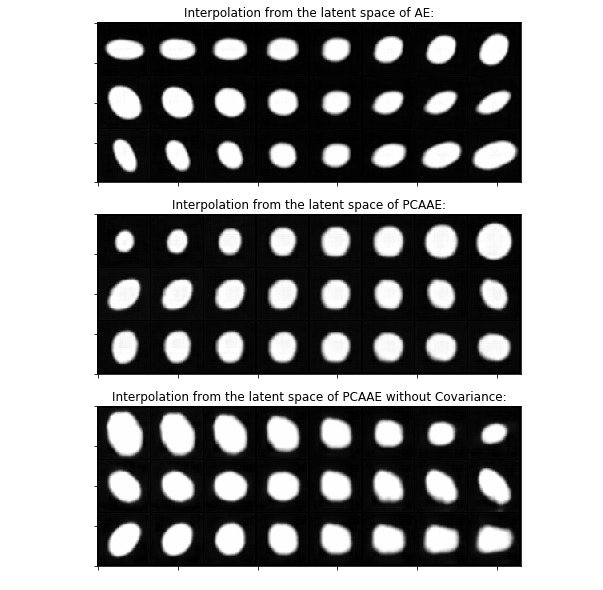

In [155]:
def test_model(model_D):
    z = torch.arange(-1,1,0.25).unsqueeze(1)
    length = len(z)
    z1_full = torch.cat((z,torch.zeros(length,1),torch.zeros(length,1)),dim=-1).to(device)
    z2_full = torch.cat((torch.zeros(length,1),z,torch.zeros(length,1)),dim=-1).to(device)
    z3_full = torch.cat((torch.zeros(length,1),torch.zeros(length,1),z),dim=-1).to(device)
    with torch.no_grad():
        recon_z1_AE = model_D(z1_full)
        recon_z2_AE = model_D(z2_full)
        recon_z3_AE = model_D(z3_full)
        recon_AE = torch.cat((recon_z1_AE,recon_z2_AE,recon_z3_AE), dim=0)
    return recon_AE
   
fig, ax = plt.subplots(figsize=(10,10))
ax.axis('off')

grid_AE = torchvision.utils.make_grid(test_model(AE_D).clamp(min=-1, max=1), scale_each=True, normalize=True).cpu().numpy()

ax1 = fig.add_subplot(3,1,1, xticklabels=[], yticklabels=[])
ax1.title.set_text("Interpolation from the latent space of AE:")
plt.imshow(grid_AE.transpose(1,2,0), cmap='gray')

grid_PCAAE = torchvision.utils.make_grid(test_model(PCAAE_D [train_latent-1]).clamp(min=-1, max=1), scale_each=True, normalize=True).cpu().numpy()

ax2 = fig.add_subplot(3,1,2, xticklabels=[], yticklabels=[])
ax2.title.set_text("Interpolation from the latent space of PCAAE:")
plt.imshow(grid_PCAAE.transpose(1,2,0), cmap='gray')

grid_PCAAE_noCov = torchvision.utils.make_grid(test_model(PCAAE_D_noCov [train_latent-1]).clamp(min=-1, max=1), scale_each=True, normalize=True).cpu().numpy()

ax3 = fig.add_subplot(3,1,3, xticklabels=[], yticklabels=[])
ax3.title.set_text("Interpolation from the latent space of PCAAE without Covariance:")
plt.imshow(grid_PCAAE_noCov.transpose(1,2,0), cmap='gray')

plt.show()

Then, we will use Pearson correlation coefficient to evaluate our models

In [156]:
def correlation(X1,X2):
        X1 = X1.squeeze()
        X2 = X2.squeeze()
        cov = ((X1-X1.mean())*(X2-X2.mean())).mean()
        cor = cov/(X1.std()*X2.std())
        return torch.abs(cor)
    
def evaluation(z,rect): 
    # Latent space 's composants
    z1 = z[:,0]
    z2 = z[:,1]
    z3 = z[:,2]

    # Ellipse area
    S = (rect).view(-1,64*64).sum(dim=-1,keepdims=True)
    # Horizontal axis
    L_1 = rect.squeeze()[:,31,:].sum(dim=-1,keepdims=True)
    # Vertical axis
    L_2 = rect.squeeze()[:,:,31].sum(dim=-1,keepdims=True)
    # Diagonal axis
    L_3 = torch.cat( [jd.squeeze().trace().unsqueeze(0) for jd in rect], dim=0).unsqueeze(1)
    # Another diagonal axis
    L_4 = torch.cat( [jd.squeeze().rot90().trace().unsqueeze(0) for jd in rect], dim=0).unsqueeze(1)
    
    # Horizontal/verical ratio
    H = torch.abs(L_1/L_2)
    # Two-diagonal-lines ratio
    V = torch.abs(L_3/L_4)
    
    # Correlations
    cor_S1 = correlation(z1,S)
    cor_S2 = correlation(z2,S)
    cor_S3 = correlation(z3,S)
     
    cor_H1 = correlation(z1,H)
    cor_H2 = correlation(z2,H)
    cor_H3 = correlation(z3,H)
    
    cor_V1 = correlation(z1,V)
    cor_V2 = correlation(z2,V)
    cor_V3 = correlation(z3,V)
    
    return ((cor_S1,cor_S2,cor_S3),(cor_H1,cor_H2,cor_H3),(cor_V1,cor_V2,cor_V3))

we compute the latent space

In [157]:
train_dataset = train_dataset.to(device)
with torch.no_grad():
    z_AE = AE_E(train_dataset)
    
    z_PCAAE = torch.cat((PCAAE_E[0](train_dataset),
                         PCAAE_E[1](train_dataset),
                         PCAAE_E[2](train_dataset),),dim=-1)
    
    z_PCAAE_noCov = torch.cat((PCAAE_E_noCov[0](train_dataset),
                               PCAAE_E_noCov[1](train_dataset),
                               PCAAE_E_noCov[2](train_dataset),),dim=-1)

Now, we show the quantitative results

In [158]:
evaluation(z_AE, train_dataset)

((tensor(0.5513, device='cuda:0'),
  tensor(0.7727, device='cuda:0'),
  tensor(0.9041, device='cuda:0')),
 (tensor(0.6090, device='cuda:0'),
  tensor(0.0012, device='cuda:0'),
  tensor(0.2046, device='cuda:0')),
 (tensor(0.4144, device='cuda:0'),
  tensor(0.3271, device='cuda:0'),
  tensor(0.2939, device='cuda:0')))

In [159]:
evaluation(z_PCAAE, train_dataset)

((tensor(0.9857, device='cuda:0'),
  tensor(0.0421, device='cuda:0'),
  tensor(0.0235, device='cuda:0')),
 (tensor(0.1229, device='cuda:0'),
  tensor(0.1632, device='cuda:0'),
  tensor(0.7351, device='cuda:0')),
 (tensor(0.0919, device='cuda:0'),
  tensor(0.7791, device='cuda:0'),
  tensor(0.1861, device='cuda:0')))

In [160]:
evaluation(z_PCAAE_noCov, train_dataset)

((tensor(0.9875, device='cuda:0'),
  tensor(0.5345, device='cuda:0'),
  tensor(0.3900, device='cuda:0')),
 (tensor(0.0700, device='cuda:0'),
  tensor(0.3947, device='cuda:0'),
  tensor(0.5235, device='cuda:0')),
 (tensor(0.1045, device='cuda:0'),
  tensor(0.0598, device='cuda:0'),
  tensor(0.4349, device='cuda:0')))